### import

In [3]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from IPython import display
from matplotlib import pyplot as plt

### Rename file

In [10]:
path='./content/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst = "covid-" + str(count) + ".png"
    src = path+ filename 
    dst = path+ dst 
        
    # rename() function will 
    # rename all the files 
    if not os.path.exists(dst):
        os.rename(src, dst)
print("Covid Positive cases: ", count)

path='./content/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    if not os.path.exists(dst):
        os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid Positive cases:  348
Covid Negative cases:  396


### Create folder

In [13]:
base_dir = './content/covid19_CT'
if not os.path.exists(base_dir): os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):os.mkdir(test_dir)

### Assign the original files to their respective folders

In [14]:
original_dataset_dir_covid = './content/CT_COVID/'
original_dataset_dir_non_covid = './content/CT_NonCOVID/'

import shutil
fnames = ['covid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst_dir = os.path.join(train_dir, '0')
    if not os.path.exists(dst_dir): os.mkdir(dst_dir)
    dst = os.path.join(dst_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['covid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst_dir = os.path.join(validation_dir, '0')
    if not os.path.exists(dst_dir): os.mkdir(dst_dir)
    dst = os.path.join(dst_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['covid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst_dir = os.path.join(test_dir, '0')
    if not os.path.exists(dst_dir): os.mkdir(dst_dir)
    dst = os.path.join(dst_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['noncovid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst_dir = os.path.join(train_dir, '1')
    if not os.path.exists(dst_dir): os.mkdir(dst_dir)
    dst = os.path.join(dst_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst_dir = os.path.join(validation_dir, '1')
    if not os.path.exists(dst_dir): os.mkdir(dst_dir)
    dst = os.path.join(dst_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst_dir = os.path.join(test_dir, '1')
    if not os.path.exists(dst_dir): os.mkdir(dst_dir)
    dst = os.path.join(dst_dir, fname)
    shutil.copyfile(src, dst)

### Creating a data set

In [15]:
IMG_SIZE = 224
batch_size = 10

def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0


normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.RandomHorizontalFlip(),  
    torchvision.transforms.ToTensor(),
    normalize])    

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    normalize])  

data_dir = './content/covid19_CT'

train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)

valid_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=test_augs),
        batch_size=batch_size)

test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)

### Let's define the training function
- Let's first define a drawing class

In [16]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

- Define a count class

In [17]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

- Define the training function

In [18]:
def accuracy(y_hat, y):
    pred = y_hat.argmax(dim = 1)
    res = pred == y
    return res.sum()

def evaluate_accuracy_gpu(net, data_iter, device=None):
    net.eval()
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), len(y))
    return metric[0] / metric[1]

def predict(net, data_iter, device=None):
    net.eval()
    preds = []
    targets =[]
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = list(y.numpy())
            y_hat = net(X)
            pred = list(y_hat.argmax(dim = 1).cpu().numpy())
            preds.extend(pred)
            targets.extend(y)
    return preds, targets

def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def train_batch(net, X, y, loss, trainer, device):
    
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, valid_iter, loss, trainer, num_epochs, device=try_gpu()):
    net = net.to(device)
    num_batches = len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'valid acc'])
    for epoch in range(num_epochs):
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            l, acc = train_batch(net, features, labels, loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[2], metric[1] / metric[3], None))
        valid_acc = evaluate_accuracy_gpu(net, valid_iter, device)
        animator.add(epoch + 1, (None, None, valid_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, valid acc {valid_acc:.3f}')

### The following is resnet101
- Training

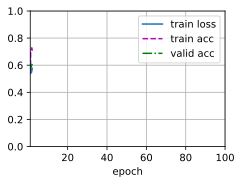

In [ ]:
feaextra_net = torchvision.models.resnet101(pretrained=True)   
feaextra_net.fc = nn.Sequential(
        nn.Linear(feaextra_net.fc.in_features, 512),
        nn.Dropout(p=0.4),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 2)        
    )  
nn.init.xavier_uniform_(feaextra_net.fc[0].weight)
nn.init.xavier_uniform_(feaextra_net.fc[3].weight)
nn.init.xavier_uniform_(feaextra_net.fc[5].weight)

def train(net, train_iter, valid_iter, loss, trainer, scheduler, num_epochs, device=try_gpu()):
    best_acc = 0
    net = net.to(device)
    num_batches = len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'valid acc'])
    for epoch in range(num_epochs):
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            l, acc = train_batch(net, features, labels, loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[2], metric[1] / metric[3], None))
        
        valid_acc = evaluate_accuracy_gpu(net, valid_iter, device)
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(net.state_dict(), 'FEresnet101.params')  
        animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    print(f'loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, valid acc {valid_acc:.3f}')

def train_feaextra(net, learning_rate, lr_period, lr_decay, num_epochs=5):
    
    device = try_gpu(1)    
    loss = nn.CrossEntropyLoss(reduction="none")
   
    trainer = torch.optim.SGD([{'params': net.fc.parameters()}], lr=learning_rate, weight_decay=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    
    train(net, train_iter, valid_iter, loss, trainer, scheduler, num_epochs, device)

lr_period, lr_decay, LR = 20, 0.5, 1e-4
train_feaextra(feaextra_net, LR, lr_period, lr_decay, num_epochs = 100)

feaextra_net.load_state_dict(torch.load('FEresnet101.params'))
valid_acc = evaluate_accuracy_gpu(feaextra_net, valid_iter, device = try_gpu(1))
print(valid_acc)

- The optimal model in training was used to calculate the evaluation index

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

train_acc = evaluate_accuracy_gpu(feaextra_net, train_iter, device = try_gpu(1))
valid_acc = evaluate_accuracy_gpu(feaextra_net, valid_iter, device = try_gpu(1))

## Test Accuracy
ypred, test_y = predict(feaextra_net, test_iter, try_gpu(1))
test_acc = accuracy_score(test_y, ypred)


precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", train_acc)
print("Val Accuracy:\t", valid_acc)
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

### The following is densenet121
- Training

In [ ]:
feaextra_net = torchvision.models.densenet121(pretrained=True) 
feaextra_net.classifier = nn.Sequential(
        nn.Linear(feaextra_net.classifier.in_features, 512),
        nn.Dropout(p=0.4),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 2)        
    )
nn.init.xavier_uniform_(feaextra_net.classifier[0].weight)
nn.init.xavier_uniform_(feaextra_net.classifier[3].weight)
nn.init.xavier_uniform_(feaextra_net.classifier[5].weight)

def train(net, train_iter, valid_iter, loss, trainer, scheduler, num_epochs, device=try_gpu()):
    best_acc = 0
    net = net.to(device)
    num_batches = len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'valid acc'])
    for epoch in range(num_epochs):
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            l, acc = train_batch(net, features, labels, loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(metric[0] / metric[2], metric[1] / metric[3], None))
        
        valid_acc = evaluate_accuracy_gpu(net, valid_iter, device)
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(net.state_dict(), 'FEdensenet121.params')   
        animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    print(f'loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, valid acc {valid_acc:.3f}')

def train_feaextra(net, learning_rate, lr_period, lr_decay, num_epochs=5):
    
    device = try_gpu(1)   
    loss = nn.CrossEntropyLoss(reduction="none")
    
    trainer = torch.optim.SGD([{'params': net.classifier.parameters()}], lr=learning_rate, weight_decay=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    
    train(net, train_iter, valid_iter, loss, trainer, scheduler, num_epochs, device)

lr_period, lr_decay, LR = 20, 0.5, 1e-4
train_feaextra(feaextra_net, LR, lr_period, lr_decay, num_epochs = 100)



feaextra_net.load_state_dict(torch.load('FEdensenet121.params'))
valid_acc = evaluate_accuracy_gpu(feaextra_net, valid_iter, device = try_gpu(1))
print(valid_acc)

- The optimal model in training was used to calculate the evaluation index

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

train_acc = evaluate_accuracy_gpu(feaextra_net, train_iter, device = try_gpu(1))
valid_acc = evaluate_accuracy_gpu(feaextra_net, valid_iter, device = try_gpu(1))

## Test Accuracy
ypred, test_y = predict(feaextra_net, test_iter, try_gpu(1))
test_acc = accuracy_score(test_y, ypred)


precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", train_acc)
print("Val Accuracy:\t", valid_acc)
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)